# Circuits, jobs and plots included in the paper

In [1]:
import qiskit
import qiskit_ibm_runtime

print(f"Qiskit version: {qiskit.version.get_version_info()}")
print(f"Qiskit IBM Runtime version: {qiskit_ibm_runtime.version.get_version_info()}")

Qiskit version: 2.2.1
Qiskit IBM Runtime version: 0.42.0


In [2]:
run_on_ibm = False

---

In [3]:
import builtins
import io
import secrets

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import TABLEAU_COLORS
from qiskit import QuantumCircuit, ClassicalRegister, generate_preset_pass_manager
from qiskit.circuit import CircuitInstruction
from qiskit.circuit.library import CZGate, Reset, grover_operator
from qiskit.converters import circuit_to_dag
from qiskit.quantum_info import hellinger_fidelity
from qiskit.visualization import plot_histogram, plot_circuit_layout
from qiskit_aer.primitives import SamplerV2 as AerSampler
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as SamplerIBM
from qiskit_ibm_runtime.fake_provider import FakeGeneva, FakeTorino

if run_on_ibm:
    # IBM Quantum Platform
    service = QiskitRuntimeService()

## Section 6.1

### Figure 6

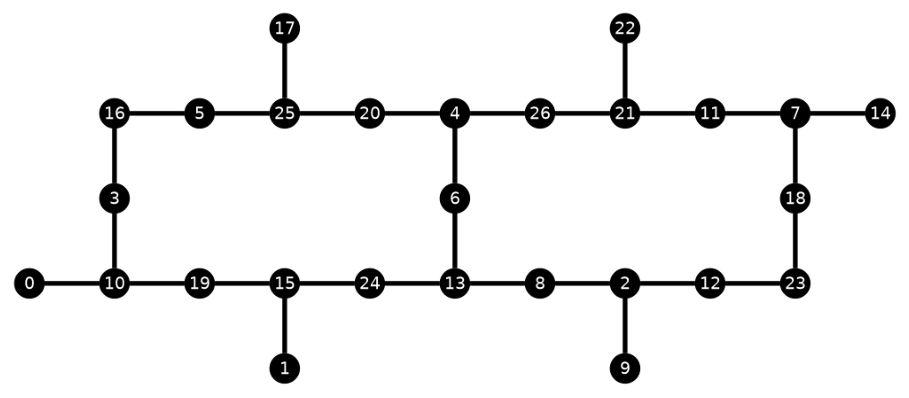

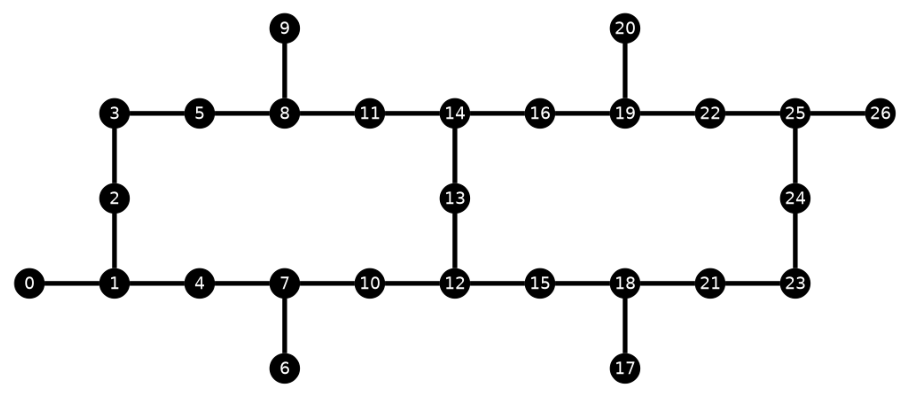

b'Hello World'


In [4]:
from qiskit_leaky_layout import recover_data

builtins.data = b"Hello World"

backend = FakeGeneva()

qc = QuantumCircuit(27)
qc.h(0)
qc.cx(0, 1)
qc.cx(0, 2)

pm = generate_preset_pass_manager(backend, layout_method="leaky_layout")
isa_qc = pm.run(qc)
display(plot_circuit_layout(isa_qc, backend, "virtual"))
display(plot_circuit_layout(isa_qc, backend, "physical"))
print(recover_data(isa_qc, isa_qc.num_qubits))
del builtins.data

## Section 6.2

### Figure 7

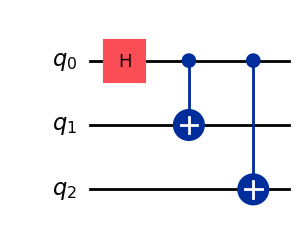

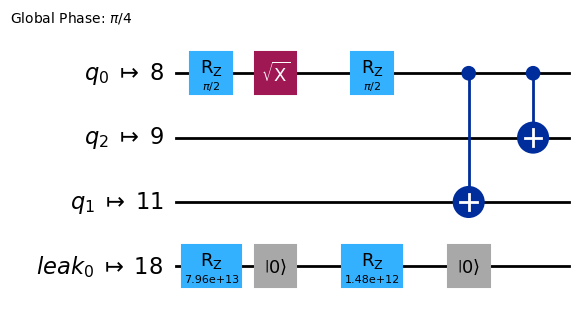

In [5]:
builtins.data = b"Hello World"

backend = FakeGeneva()

qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, 1)
qc.cx(0, 2)
display(qc.draw("mpl"))

pm = generate_preset_pass_manager(backend, init_method="leaky_init")
isa_qc = pm.run(qc)
display(isa_qc.draw("mpl", fold=False))
del builtins.data

### Figure 7 (alt)

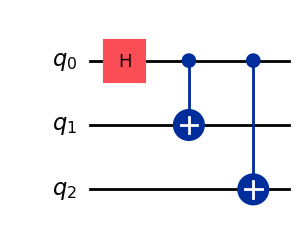

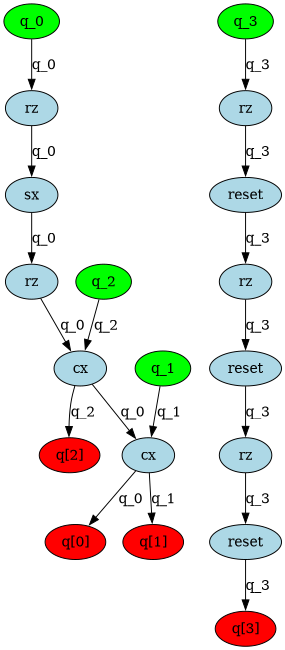

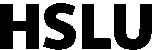

In [6]:
builtins.block_size = 128
backend = FakeGeneva()

qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, 1)
qc.cx(0, 2)
display(qc.draw("mpl"))

pm = generate_preset_pass_manager(backend, init_method="leaky_init")
isa_qc = pm.run(qc)
dag = circuit_to_dag(isa_qc)

for iddle_qubit in isa_qc.layout.initial_index_layout()[4:]:
    dag.remove_qubits(isa_qc.qubits[iddle_qubit])

display(dag.draw())

# With modern versions of Qiskit it is no longer possible to hide 128 bytes per
# rotation gate, so we use the default value of the plugin (6 bytes) to show that
# recovering the hidden data works as expected.
del builtins.block_size
isa_qc = pm.run(qc)

from qiskit_leaky_init import recover_data
hslu_logo = recover_data(isa_qc)

display(Image.open(io.BytesIO(hslu_logo)))

## Section 6.3

#### Figure 9

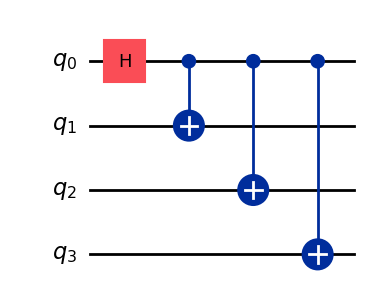

In [7]:
# Heron r1 QPU with 133 qubits
backend = FakeTorino()

random_data = secrets.token_bytes(65)
builtins.data = random_data

qc = QuantumCircuit(4)
qc.h(0)
qc.cx(0, range(1, 4))
display(qc.draw("mpl"))
qc.measure_all()

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_qc = pm.run(qc)

assert isa_qc.count_ops()["rz"] == 11

pm = generate_preset_pass_manager(backend=backend, optimization_level=3, scheduling_method="leaky_rotations")
isa_qc_mod = pm.run(qc)

assert isa_qc_mod.count_ops()["rz"] == 11
del builtins.data

<div class="alert alert-block alert-danger">

This job is expected to use ~1 min of your IBM Open Plan monthly time.
</div>

In [8]:
num_shots = 100_000

if run_on_ibm:
    backend = service.backend("ibm_torino")
    sampler = SamplerIBM(mode=backend)
    job = sampler.run([isa_qc, isa_qc_mod], shots=num_shots)
    job_id = job.job_id()
    print(f"job_id: {job_id}")

In [9]:
if run_on_ibm:
    # job_id = "d344hue6pnbs739j5160"
    job = service.job(job_id)
    job.wait_for_final_state()
    result = job.result()
    counts = result[0].data.meas.get_counts()
    counts_mod = result[1].data.meas.get_counts()

    print(f"Hellinger fidelity: {hellinger_fidelity(counts, counts_mod):.4f}")

    from qiskit_leaky_scheduling import recover_data
    recovered_data = recover_data(isa_qc_mod)
    print(f"Data recovered? {random_data == recovered_data}")
    
    fig, ax = plt.subplots(constrained_layout=True)
    plot_histogram(counts, ax=ax)
    ax.grid(visible=False)

    fig, ax = plt.subplots(constrained_layout=True)
    plot_histogram(counts_mod, ax=ax)
    ax.grid(visible=False)

#### Figure 10

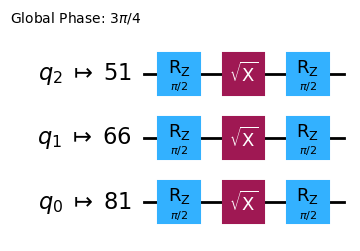

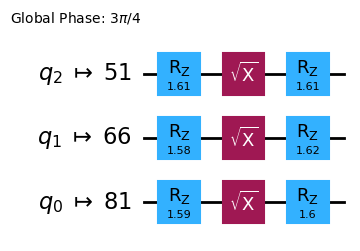

In [10]:
qc = QuantumCircuit(3)
qc.h(range(3))
qc.draw("mpl")

from qiskit_ibm_runtime.fake_provider import FakeBrisbane

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_qc = pm.run(qc)
display(isa_qc.draw("mpl"))

random_data = secrets.token_bytes(6 * isa_qc.count_ops()["rz"])
builtins.data = random_data
pm = generate_preset_pass_manager(backend=backend, optimization_level=3, scheduling_method="leaky_rotations")
isa_qc_mod = pm.run(qc)
display(isa_qc_mod.draw("mpl"))
del builtins.data

## Section 7.1

#### Figure 11

In [11]:
def gen_benchmarking_circuit(num_qubits):
    qc = QuantumCircuit(num_qubits)
    meas = ClassicalRegister(2, "meas")
    qc.add_register(meas)
    qc.h(0)
    [qc.cx(i, i + 1) for i in range(num_qubits - 1)]
    qc.barrier()
    qc.measure([0, num_qubits - 1], [meas[0], meas[1]])
    return qc

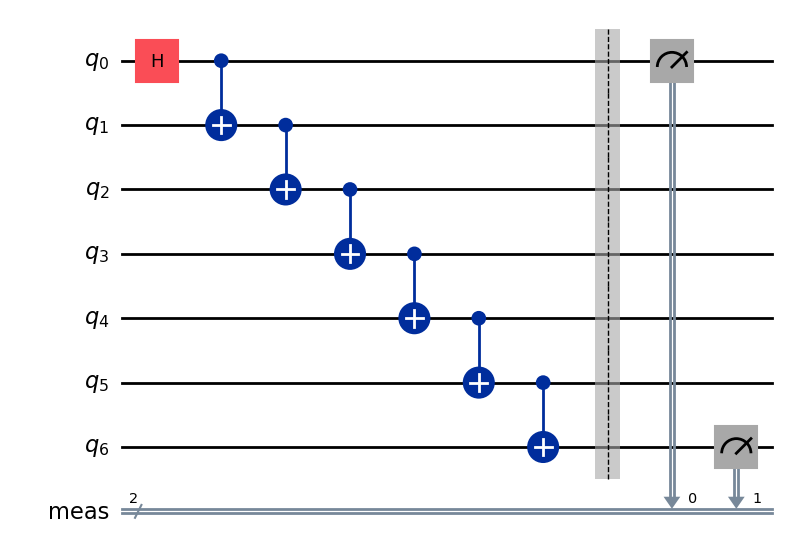

In [12]:
qc = gen_benchmarking_circuit(7)
qc.draw("mpl", fold=False)

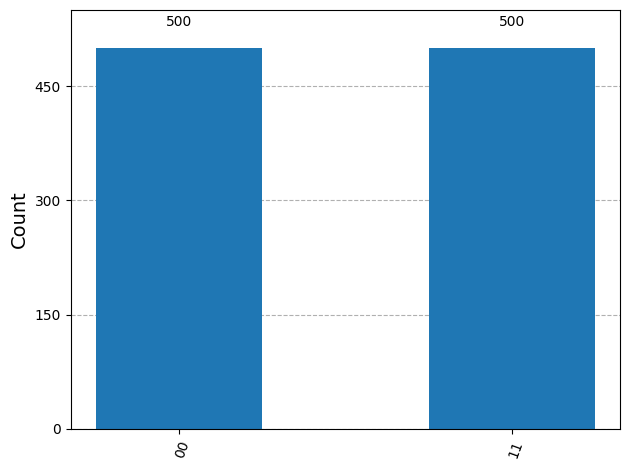

In [13]:
counts = {"00": 500, "11": 500}
plot_histogram(counts)

#### Figure 12

In [14]:
# Random seed fixed for reproducibility. Delete the fixed seed and uncomment the next line for a fresh random seed.
#seed_transpiler = secrets.randbits(64)
seed_transpiler = 1062981512974188944
# Pass manager for transpilation
pm = generate_preset_pass_manager(backend=backend, optimization_level=3, seed_transpiler=seed_transpiler)
# Transpiled circuit with only ISA instructions
isa_qc = pm.run(qc)
# Mapping of the first and last qubits
first_qubit = isa_qc.layout.initial_index_layout()[0]
last_qubit = isa_qc.layout.initial_index_layout()[6]
print(f"depth transpiled circuit: {isa_qc.depth()}")
print(f"size transpiled circuit: {isa_qc.size()}")

depth transpiled circuit: 22
size transpiled circuit: 41


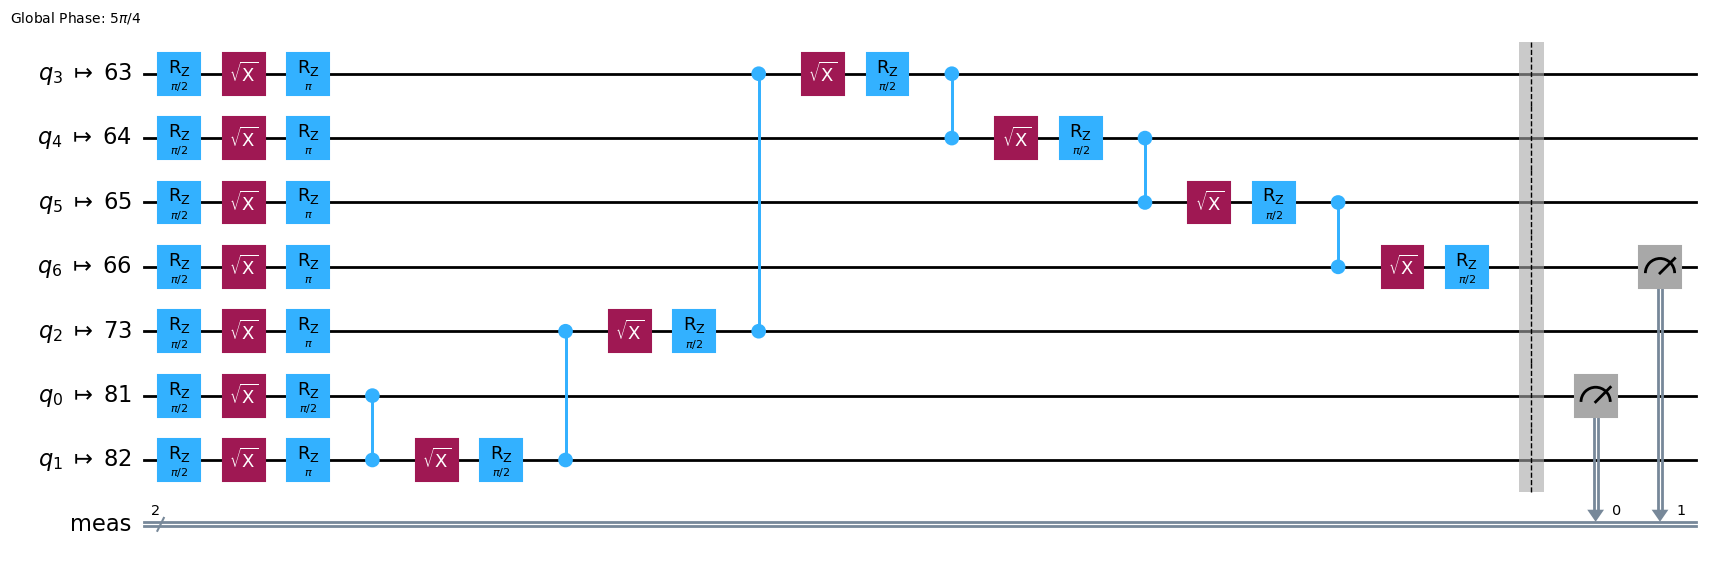

In [15]:
isa_qc.draw("mpl", fold=False)

First, the attack adding a reset instruction.

In [16]:
for i, ins in enumerate(isa_qc.data):
    if ins.operation.name == "barrier":
        target_instruction = i

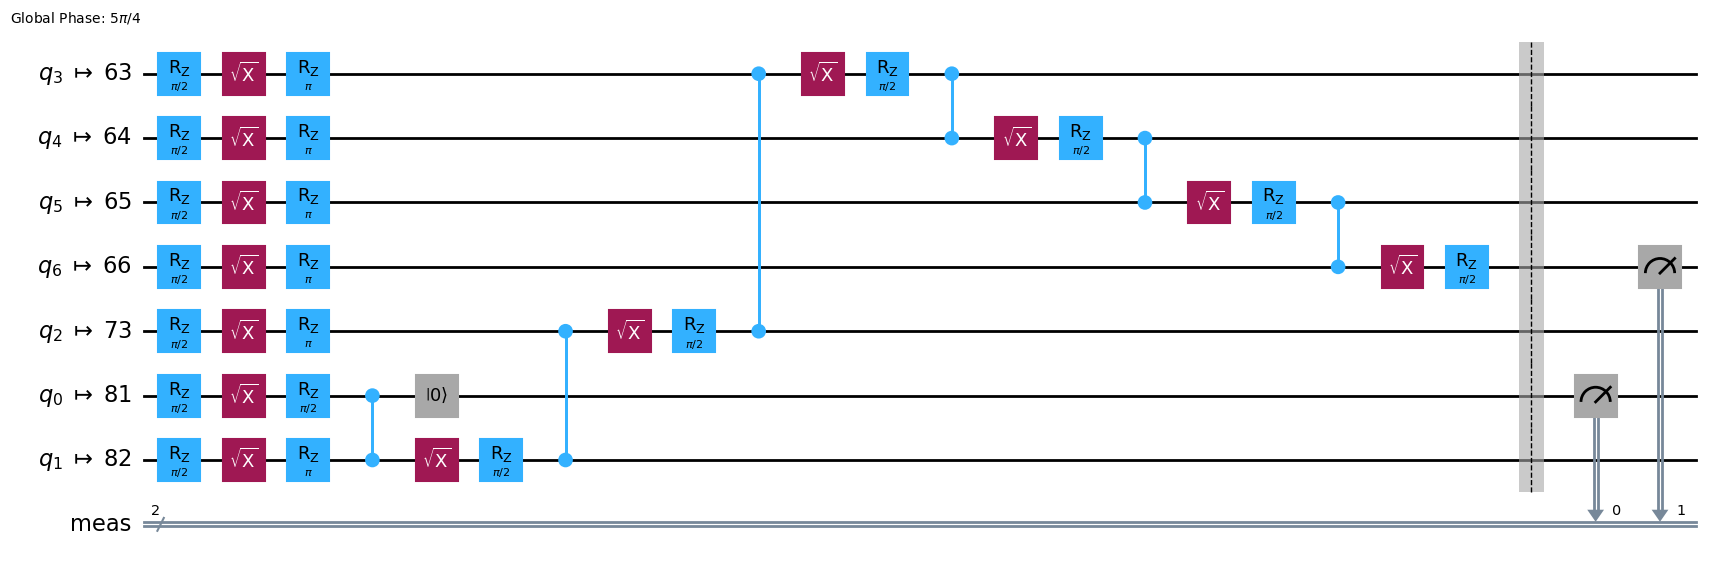

In [17]:
isa_qc_mod = isa_qc.copy()
isa_qc_mod.data.insert(target_instruction, CircuitInstruction(Reset(), qubits=[first_qubit]))
isa_qc_mod.draw("mpl")

<div class="alert alert-block alert-danger">

This job is expected to use ~1 min of your IBM Open Plan monthly time.
</div>

In [18]:
n_shots = 100_000

if run_on_ibm:
    backend = service.backend("ibm_torino")
    sampler = SamplerIBM(mode=backend)
    job = sampler_ibm.run([isa_qc, isa_qc_mod], shots=n_shots)
    job_id = job.job_id()
    print(f"job id: {job_id}")

In [19]:
if run_on_ibm:
    # job_id = "d317rvhmc66s738e14c0"
    job = service.job(job_id)
    job.wait_for_final_state()
    results = job.result()
    counts_unmodified = results[0].data.meas.get_counts()
    counts_modified = results[1].data.meas.get_counts()

In [20]:
if run_on_ibm:
    fig, ax = plt.subplots(constrained_layout=True)
    colors = list(TABLEAU_COLORS.values())
    c1 = colors[0]
    c2 = colors[1]
    plot_histogram([counts_unmodified, counts_modified], color=[c1, c2], ax=ax)
    legend = ax.legend(["Unmodified circuit", "Modified circuit"], loc=1)
    legend.legend_handles[0].set_facecolor(c1)
    legend.legend_handles[0].set_edgecolor(c1)
    legend.legend_handles[1].set_facecolor(c2)
    legend.legend_handles[1].set_edgecolor(c2)

And now the attack modifying the CZ gate entangling the last qubit.

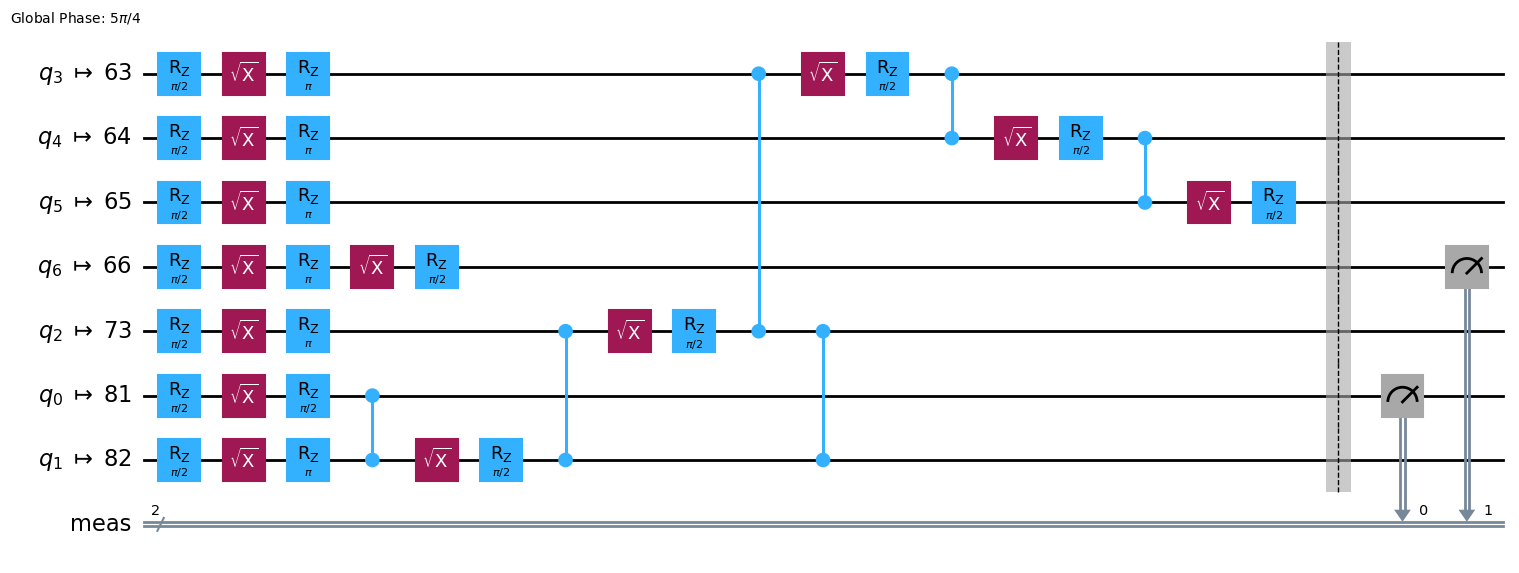

In [21]:
isa_qc_mod = isa_qc.copy()

for i, ins in enumerate(isa_qc_mod.data):
    if ins.operation.name == "cz":
        if isa_qc_mod.qubits[last_qubit] in ins.qubits:
            del isa_qc_mod.data[i]
            isa_qc_mod.data.insert(i, CircuitInstruction(CZGate(), qubits=tuple([isa_qc_mod.qubits[82], isa_qc_mod.qubits[73]])))

isa_qc_mod.draw("mpl")

<div class="alert alert-block alert-danger">

This job is expected to use ~1 min of your IBM Open Plan monthly time.
</div>

In [22]:
if run_on_ibm:
    sampler = SamplerIBM(mode=backend)
    job = sampler_ibm.run([isa_qc, isa_qc_mod], shots=n_shots)
    job_id = job.job_id()
    print(f"job id: {job_id}")

In [23]:
if run_on_ibm:
    # job_id = "d30p6bbnfo5s73bhuq9g"
    job = service.job(job_id)
    job.wait_for_final_state()
    results = job.result()
    counts_unmodified = results[0].data.meas.get_counts()
    counts_modified = results[1].data.meas.get_counts()

In [24]:
if run_on_ibm:
    fig, ax = plt.subplots(constrained_layout=True)
    colors = list(TABLEAU_COLORS.values())
    c1 = colors[0]
    c2 = colors[1]
    plot_histogram([counts_unmodified, counts_modified], figsize=(8, 5), color=[c1, c2], ax=ax)
    legend = ax.legend(["Unmodified circuit", "Modified circuit"], loc=1)
    legend.legend_handles[0].set_facecolor(c1)
    legend.legend_handles[0].set_edgecolor(c1)
    legend.legend_handles[1].set_facecolor(c2)
    legend.legend_handles[1].set_edgecolor(c2)

## Section 7.2

#### Figure 13

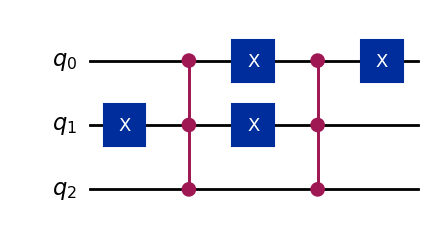

In [25]:
qc_oracle = QuantumCircuit(3)
# Marks state 101
qc_oracle.x(1)
qc_oracle.ccz(0, 1, 2)
qc_oracle.x(1)
# Marks state 110
qc_oracle.x(0)
qc_oracle.ccz(0, 1, 2)
qc_oracle.x(0)
qc_oracle.draw("mpl")

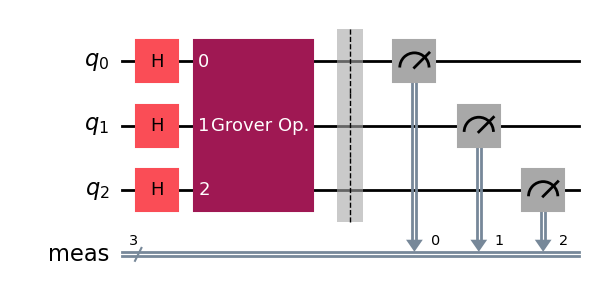

In [26]:
grover_op = grover_operator(qc_oracle, name="Grover Op.")
qc_grover = QuantumCircuit(grover_op.num_qubits)
qc_grover.h(range(grover_op.num_qubits))
qc_grover.compose(grover_op.power(1), inplace=True)
qc_grover.measure_all()
display(qc_grover.draw("mpl"))

In [27]:
# Random seed fixed for reproducibility. Delete the fixed seed and uncomment the next line for a fresh random seed.
# seed = secrets.randbits(64)
seed = 13922476891334822750

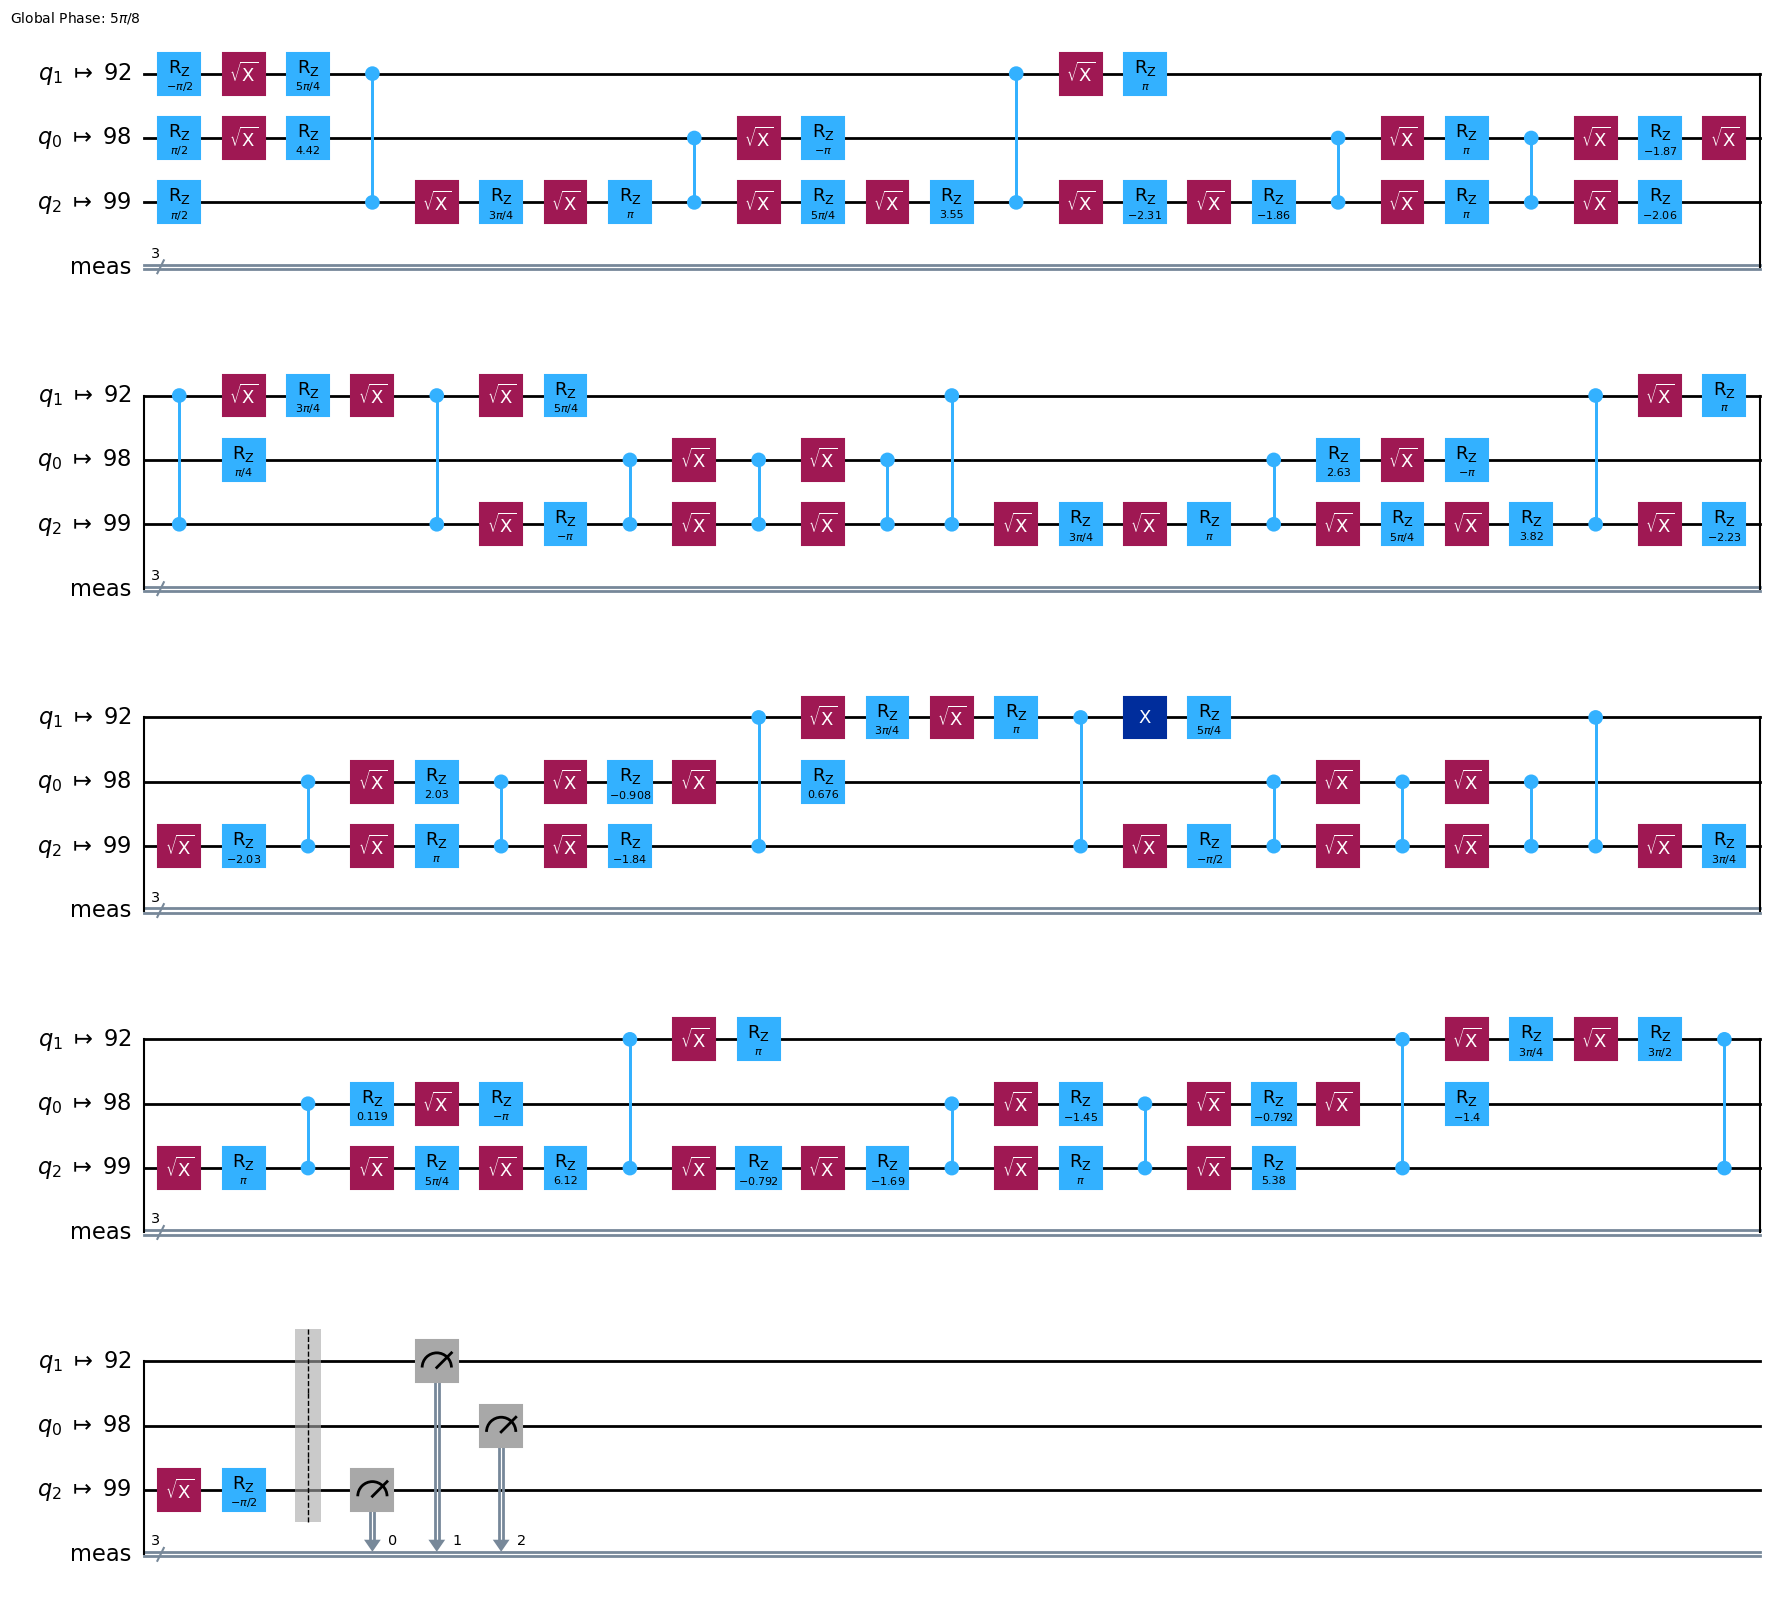

In [28]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=3, seed_transpiler=seed)
isa_qc_grover = pm.run(qc_grover)
isa_qc_grover = pm.run(qc_grover)
isa_qc_grover.draw("mpl")

In [29]:
for i, ins in enumerate(isa_qc_grover.data):
    if ins.operation.name == "cz":
        target_instruction = i

In [30]:
isa_qc_grover_mod = isa_qc_grover.copy()
print(isa_qc_grover.data[target_instruction])
del isa_qc_grover_mod.data[target_instruction]
isa_qc_grover_mod.data.insert(target_instruction, CircuitInstruction(CZGate(), qubits=[65, 66]))
print(isa_qc_grover_mod.data[target_instruction])

CircuitInstruction(operation=Instruction(name='cz', num_qubits=2, num_clbits=0, params=[]), qubits=(<Qubit register=(133, "q"), index=99>, <Qubit register=(133, "q"), index=92>), clbits=())
CircuitInstruction(operation=Instruction(name='cz', num_qubits=2, num_clbits=0, params=[]), qubits=(<Qubit register=(133, "q"), index=65>, <Qubit register=(133, "q"), index=66>), clbits=())


<div class="alert alert-block alert-danger">

This job is expected to use ~1 min of your IBM Open Plan monthly time.
</div>

In [31]:
n_shots = 100_000

if run_on_ibm:
    job = sampler_ibm.run([isa_qc_grover, isa_qc_grover_mod], shots=n_shots)
    job_id = job.job_id()
    print(f"job id: {job_id}")

In [32]:
if run_on_ibm:
    # job_id = "d31g8nhmc66s738e961g"
    job = service.job(job_id)
    job.wait_for_final_state()
    results = job.result()
    counts_unmodified = results[0].data.meas.get_counts()
    counts_modified = results[1].data.meas.get_counts()

In [33]:
if run_on_ibm:
    # Unmodified
    fig, ax = plt.subplots(constrained_layout=True)
    plot_histogram(counts_unmodified, ax=ax)

    # Modified
    fig, ax = plt.subplots(constrained_layout=True)
    plot_histogram(counts_modified, ax=ax)